# Feature Selection using Wrapper Methods

Primeramente realizamos los diferentes imports necesarios para poder alcanzar el objetivo de abordar la problemática de selección de características

In [2]:
import pandas as pd # pandas nos permitirá analizar y manipular los conjuntos de datos proporcionados en formato .csv
import numpy as np  # numpy nos permitirá trabajar con vectores, matrices, en general nos aporta un conjunto de bibliotecas matemáticas de alto nivel
from sklearn import tree # nos proporciona la forma de trabajar con DT (Decission Trees) 
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split #Para dividir un conjunto de datos en un subconjunto de entrenamiento y otro de prueba
#from sklearn import datasets,linear_model # Para explorar otros conjuntos de datos y estimadores.
from sklearn.datasets import load_iris # Para obtener otro conjunto de datos con los que experimentar
from time import time # Para los tiempos de ejecución de los algoritmos
from sklearn import svm
import copy
from sklearn.model_selection import cross_val_score # Nos permitirá efectuar la validación cruzada
from sklearn.metrics import confusion_matrix # Empleado para experimentar con los datos
from sklearn.metrics import balanced_accuracy_score #Métrica que utilizaremos para evaluar la capacidad predictiva del algoritmo

### Primera aproximación a los datos

Exploramos los diferentes conjuntos de datos y la función de cross_val_score

In [3]:
titanic_passangers = pd.read_csv('titanic.csv') # Muestra de pasajeros del titanic
titanic_passangers.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat,Deck,Title,Is_Married,Survived
0,3,0,22.0,1,0,7.2500,0,0,1,1,0,0,7,11,0,0
1,1,1,38.0,1,0,71.2833,1,1,2,1,0,3,2,12,1,1
2,3,1,26.0,0,0,7.9250,0,2,1,0,1,1,7,8,0,1
3,1,1,35.0,1,0,53.1000,0,1,2,1,0,3,2,12,1,1
4,3,0,35.0,0,0,8.0500,0,0,2,0,1,1,7,11,0,0
5,3,0,33.0,0,0,8.4583,2,0,2,0,1,1,7,11,0,0
6,1,0,54.0,0,0,51.8625,0,0,3,0,1,3,4,11,0,0
7,3,0,2.0,3,1,21.0750,0,3,0,4,0,2,7,7,0,0
8,3,1,27.0,0,2,11.1333,0,1,1,2,0,1,7,12,1,1
9,2,1,14.0,1,0,30.0708,1,1,0,1,0,2,7,12,1,1


In [4]:
#Filtering data to attributes and objective or target
X = titanic_passangers.iloc[:, 0:15]
y = titanic_passangers.iloc[:, 15]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
DT = tree.DecisionTreeClassifier(criterion='entropy')
DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)
matriz= confusion_matrix(y_test,y_pred)
print(matriz)
precision = balanced_accuracy_score(y_test,y_pred)
print(precision)


T = titanic_passangers.iloc[:, 0:13]
r = titanic_passangers.iloc[:, 15]
np.array(T)
np.array(r)
scores = cross_val_score(DT,T,r,cv=10, scoring='balanced_accuracy')
print(scores)

[[91 14]
 [17 57]]
0.8184684684684684
[0.70519481 0.75294118 0.65909091 0.79010695 0.80962567 0.79278075
 0.77245989 0.7473262  0.79705882 0.7973545 ]


La matriz de confusión nos permite ver el desempeño del algoritmo. La diagonal principal nos muestra los positivos (verdaderos positivos y verdaderos negativos) y la secundaria los negativos (falsos negativos y falsos positivos).

## Implementación

Ahora procedemos a definir la función encargada de realizar la evaluación de cada uno de los subconjuntos de variables predictoras. \
**data** = conjunto de datos original \
**variables** = subconjunto de variables predictoras \
**N_Exp** =  Número de experimentos, por defecto le pasamos 10 \
**CV** = Número de folds, por defecto le pasamos 10

In [3]:
def evaluacion_soluciones_robusta(data, variables, N_Exp=10, CV=10):
    DT = tree.DecisionTreeClassifier(criterion='entropy')
    X = data[variables]   #varibles predictoras
    y = data.iloc[:, -1] #variable objetivo
    resultado_promedio = 0
    i = 0
    while N_Exp > i:
        i = i + 1
        aciertos = cross_val_score(DT, X, y , cv=CV, scoring='balanced_accuracy')
        suma_total = 0
        for acierto in aciertos:
            suma_total= suma_total + acierto
        resultado_promedio = resultado_promedio + (suma_total/len(aciertos))
    return resultado_promedio/N_Exp

En la siguiente celda definimos el algoritmo de búsqueda secuencial hacia adelante \
**data** = conjunto de datos original. \
**D** = número máximo de variables a probar, por defecto D será igual al número de variables predictoras de data.

In [6]:
def sequential_forward_selection(data, D=None):
    start_time = time()
    if D is None:
        D = len(data.columns.values.tolist()) -1 
    mejores_soluciones = pd.DataFrame(columns=['solution','score','size']) # tabla con los diferentes resultados
    solucion_actual = list() # almacena el mejor subconjunto en cada iteración
    caracteristicas = data.columns.tolist()
    variables_predictoras = caracteristicas[:-1] # lista con todas las variables predictoras
    rendimiento_temporal = 0
    variables_actuales = list() # almacena el subconjunto de manera temporal
    K = 0
    while K < D:
        for var in variables_predictoras:
            if var not in solucion_actual:
                solucion_temporal = copy.copy(solucion_actual)
                solucion_temporal.append(var)
                rendimiento = evaluacion_soluciones_robusta(data,solucion_temporal)
                if rendimiento >= rendimiento_temporal:
                    rendimiento_temporal = rendimiento
                    variables_actuales = copy.copy(solucion_temporal)
                solucion_temporal = list()
        solucion_actual = variables_actuales
        nueva_fila = pd.Series(data={'solution': solucion_actual, 'score': rendimiento_temporal, 'size':len(solucion_actual)})
        mejores_soluciones = mejores_soluciones.append(nueva_fila,ignore_index=True)
        rendimiento_temporal = 0
        K = K + 1
    elapsed_time = time() - start_time
    print("Elapsed time: %0.10f seconds." % elapsed_time)
    return mejores_soluciones.sort_values(by=['score'],ascending=False)      

Finalmente, abordamos el algoritmo **SFFS**, un algoritmo secuencial mixto, similar al algoritmo presentado anteriormente, con la diferencia que en cada iteración nos permite eliminar una variable que hubieramos añadido previamente. \
**umbral** = valor para evaluar la condición de parada de este algoritmo. Por defecto este valor será 10 y la motivación de este valor es debida a la aleatoriedad existente en cada uno de los experimentos realizados. 

**Comentario**: Decidimos utilizar esta condición = ' if variable not in eliminados and len(solucion_actual) > 1:' ya que si eliminamos una variable daría problemas al intentar evaluar el rendimiento de un subconjunto de características vacío


In [9]:
def sequential_floating_forward_selection(data, umbral=10):
    start_time = time()
    mejores_soluciones = pd.DataFrame(columns=['solution','score','size']) # tabla con los diferentes resultados
    caracteristicas = data.columns.tolist()
    solucion_actual = list()
    anyadidos = list() # Almacena las variables que han sido añadidas
    eliminados = list() #Almacena las variables que han sido eliminadas
    variables_originales = caracteristicas[:-1]  # lista con todas las variables predictoras
    K = 0 # Contador de iteraciones
    while K != umbral:
        if len(anyadidos) == len(variables_originales):
            K = K + 1
        else:
            rendimiento_temporal = 0
        # Fase en la que añadimos la mejor variable 
            for var in variables_originales:
                if var not in solucion_actual and var not in anyadidos:
                    subconjunto = copy.copy(solucion_actual) 
                    subconjunto.append(var)
                    rendimiento = evaluacion_soluciones_robusta(data,subconjunto)
                    if rendimiento > rendimiento_temporal:
                        rendimiento_temporal = rendimiento
                        mejor_subconjunto = copy.copy(subconjunto)
                    subconjunto = list()
            solucion_actual = mejor_subconjunto
            anyadidos.append(solucion_actual[-1])
        rendimiento_temporal2 = rendimiento_temporal
        #Fase en la que eliminamos la peor variable
        for variable in solucion_actual:
            if variable not in eliminados and len(solucion_actual) > 1:
                subconjunto = copy.copy(solucion_actual)
                subconjunto.remove(variable)
                rendimiento2 = evaluacion_soluciones_robusta(data,subconjunto)
                if rendimiento2 > rendimiento_temporal2:
                    rendimiento_temporal2 = rendimiento2
                    variable_eliminada = variable
                subconjunto = list()
        solucion_temporal = copy.copy(solucion_actual)
        if rendimiento_temporal2>rendimiento_temporal:
            eliminados.append(variable_eliminada)
            solucion_temporal.remove(variable_eliminada)
            solucion_actual = copy.copy(solucion_temporal) #Ahora tenemos la solucion actualizada
            K = 0 # Si hemos eliminado una variable tenemos que resetear el contador K
            rendimiento_temporal = rendimiento_temporal2
            nueva_fila = pd.Series(data={'solution': solucion_actual, 'score': rendimiento_temporal, 'size':len(solucion_actual)})
            mejores_soluciones = mejores_soluciones.append(nueva_fila,ignore_index=True)
        else:
            nueva_fila = pd.Series(data={'solution': solucion_actual, 'score': rendimiento_temporal, 'size':len(solucion_actual)})
            mejores_soluciones = mejores_soluciones.append(nueva_fila,ignore_index=True)
    elapsed_time = time() - start_time
    print("Elapsed time: %0.10f seconds." % elapsed_time)
    return mejores_soluciones.sort_values(by=['score'],ascending=False)

Finalmente, para poder analizar mejor los resultados creamos una función que nos permite mostrar la evolución de la capacidad predictiva con respecto al número de variables consideradas, para cada algoritmo de búsqueda y cada conjunto de datos. \
**type** = si se le pasa valor 0 muestra las gráficas para el algoritmo SFS , si se le pasa 1 muestra las gráficas para el SFFS. 

In [8]:
def graficar_resultados(data,type):
    if type == 0:
        a = sequential_forward_selection(data)
        b =a.sort_values(by=['size'],ascending=True)
        lon = len(list(a['size']))
        plt.plot(np.arange(1,lon +1),list(b['score']))
        plt.xlabel('Numero de características')
        plt.xticks(np.arange(1,lon +1))
        plt.ylabel('Rendimiento')
    if type == 1: 
        a = sequential_floating_forward_selection(data)
        b =a.sort_values(by=['size'],ascending=True)
        plt.plot(list(b['size']),list(b['score']))
        plt.xlabel('Numero de características')
        plt.xticks(list(b['size']))
        plt.ylabel('Rendimiento')
    return plt.show()

Ahora presentaremos los diferentes resultados obtenidos, para estos experimentos utilizaremos los valores por defecto anteriormente mencionados: N_Exp, Cv y umbral con valor 10.

Primeramente para el conjunto de datos de Titanic

Mostramos los resultados de aplicar el SFS a ese conjunto de datos

In [9]:
data = pd.read_csv('titanic.csv')
sequential_forward_selection(data)

Elapsed time: 46.2384052277 seconds.


,solution,score,size
4,"[Initial, SibSp, Deck, Fare_cat, Title]",0.818232,5
5,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.818232,6
6,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.818232,7
7,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.813820,8
3,"[Initial, SibSp, Deck, Fare_cat]",0.811655,4
2,"[Initial, SibSp, Deck]",0.809191,3
8,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.808759,9
1,"[Initial, SibSp]",0.805218,2
9,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.803501,10
10,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.801183,11


Elapsed time: 45.5020308495 seconds.


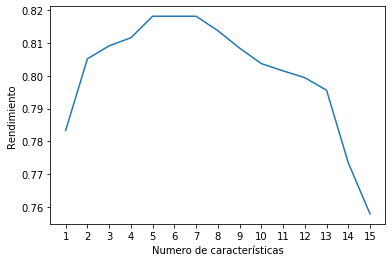

In [10]:
graficar_resultados(data,0)

Ahora para el mismo conjunto de datos aplicaremos el algoritmo SFFS

In [10]:
data = pd.read_csv('titanic.csv')
sequential_floating_forward_selection(data)

Elapsed time: 102.2459971905 seconds.


,solution,score,size
12,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
13,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
23,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
22,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
21,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
20,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
19,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
18,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
17,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7
16,"[Initial, SibSp, Deck, Fare_cat, Title, Sex, I...",0.818232,7


Elapsed time: 114.1380801201 seconds.


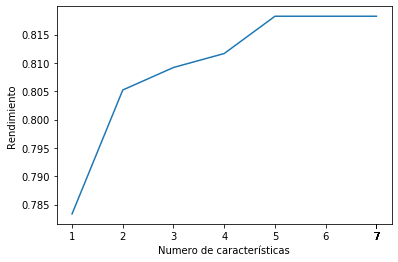

In [12]:
graficar_resultados(data,1)

Ahora realizaremos los mismos experimentos pero para el conjunto de datos de Cancer de mama

In [13]:
data2 = pd.read_csv('BreastCancerDataset.csv')
a = sequential_forward_selection(data2)

Elapsed time: 278.9196770191 seconds.


In [14]:
a

,solution,score,size
7,"[worst concave points, worst area, mean textur...",0.961627,8
12,"[worst concave points, worst area, mean textur...",0.961587,13
10,"[worst concave points, worst area, mean textur...",0.961494,11
9,"[worst concave points, worst area, mean textur...",0.960304,10
11,"[worst concave points, worst area, mean textur...",0.959424,12
8,"[worst concave points, worst area, mean textur...",0.959234,9
13,"[worst concave points, worst area, mean textur...",0.958851,14
14,"[worst concave points, worst area, mean textur...",0.958131,15
15,"[worst concave points, worst area, mean textur...",0.957648,16
6,"[worst concave points, worst area, mean textur...",0.957595,7


In [15]:
solution = a.at[6,'solution']
solution

['worst concave points',
 'worst area',
 'mean texture',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'mean concavity']

Elapsed time: 294.2163362503 seconds.


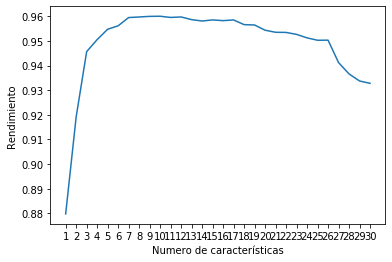

In [16]:
graficar_resultados(data2,0)

In [18]:
data2 = pd.read_csv('BreastCancerDataset.csv')
sequential_floating_forward_selection(data2)

Elapsed time: 458.2205862999 seconds.


,solution,score,size
12,"[worst concave points, worst area, mean textur...",0.961486,10
13,"[worst concave points, worst area, mean textur...",0.961378,11
11,"[worst concave points, worst area, mean textur...",0.961330,10
14,"[worst concave points, worst area, mean textur...",0.960868,11
8,"[worst concave points, worst area, mean textur...",0.960655,8
7,"[worst concave points, worst area, mean textur...",0.960084,8
6,"[worst concave points, worst area, mean textur...",0.959940,7
10,"[worst concave points, worst area, mean textur...",0.959893,9
18,"[worst concave points, worst area, mean textur...",0.959534,13
15,"[worst concave points, worst area, mean textur...",0.959313,11


Elapsed time: 441.0049970150 seconds.


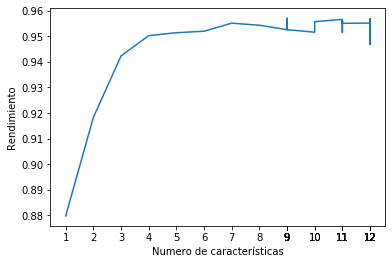

In [19]:
graficar_resultados(data2,1)

### Mejoras implementadas

Ahora presentamos alguna de las mejoras aplicables a la función de evalución de soluciones robusta y sffs. Ahora a estas funciones se le puede pasar como parámetros el estimador y la métrica que se prefiera

In [20]:
def evaluacion_soluciones_robusta_mejorada(data, variables, estimator, metric, N_Exp=10, CV=10):
    X = data[variables]   #varibles predictoras
    y = data.iloc[:, -1] #variable objetivo
    resultado_promedio = 0
    i = 0
    while N_Exp > i:
        i = i + 1
        aciertos = cross_val_score(estimator, X, y , cv=CV, scoring=metric)
        suma_total = 0
        for acierto in aciertos:
            suma_total= suma_total + acierto
        resultado_promedio = resultado_promedio + (suma_total/len(aciertos))
    return resultado_promedio/N_Exp

In [21]:
def sequential_forward_selection_mejorada(data,estimator, metric, D=None):
    if D is None:
        D = len(data.columns.values.tolist()) -1 
    mejores_soluciones = pd.DataFrame(columns=['solution','score','size']) # tabla con los diferentes resultados
    solucion_actual = list() # almacena el mejor subconjunto en cada iteración
    caracteristicas = data.columns.tolist()
    variables_predictoras = caracteristicas[:-1] # lista con todas las variables predictoras
    rendimiento_temporal = 0
    variables_actuales = list() # almacena el subconjunto de manera temporal
    K = 0
    while K < D:
        for var in variables_predictoras:
            if var not in solucion_actual:
                solucion_temporal = copy.copy(solucion_actual)
                solucion_temporal.append(var)
                rendimiento = evaluacion_soluciones_robusta_mejorada(data,solucion_temporal,estimator,metric)
                if rendimiento >= rendimiento_temporal:
                    rendimiento_temporal = rendimiento
                    variables_actuales = copy.copy(solucion_temporal)
                solucion_temporal = list()
        solucion_actual = variables_actuales
        nueva_fila = pd.Series(data={'solution': solucion_actual, 'score': rendimiento_temporal, 'size':len(solucion_actual)})
        mejores_soluciones = mejores_soluciones.append(nueva_fila,ignore_index=True)
        rendimiento_temporal = 0
        K = K + 1
    return mejores_soluciones.sort_values(by=['score'],ascending=False)  

### Explorando resultados con la nuevas mejoras

In [22]:
estimator = tree.DecisionTreeClassifier(criterion='entropy')
metric = 'balanced_accuracy'
sequential_forward_selection_mejorada(data,estimator,metric)

,solution,score,size
4,"[Initial, SibSp, Deck, Fare_cat, Title]",0.818232,5
5,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.818232,6
6,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.818232,7
7,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.813820,8
3,"[Initial, SibSp, Deck, Fare_cat]",0.811655,4
2,"[Initial, SibSp, Deck]",0.809191,3
8,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.808495,9
1,"[Initial, SibSp]",0.805218,2
9,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.803860,10
11,"[Initial, SibSp, Deck, Fare_cat, Title, Is_Mar...",0.802563,12


### Explorando otros conjuntos de datos

In [23]:
iris = load_iris()
dataIris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
estimador = tree.DecisionTreeClassifier(criterion='entropy')
metrica = 'balanced_accuracy'
sequential_forward_selection_mejorada(dataIris,estimador,metrica)

,solution,score,size
2,"[petal width (cm), petal length (cm), sepal wi...",0.960000,3
3,"[petal width (cm), petal length (cm), sepal wi...",0.958667,4
0,[petal width (cm)],0.953333,1
1,"[petal width (cm), petal length (cm)]",0.946667,2
